In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-31 15:36:56.905307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 15:36:57.566715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

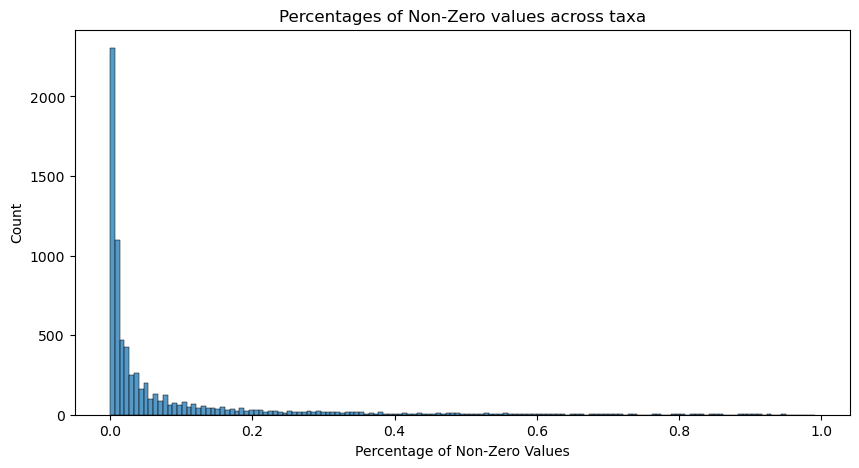

In [3]:
non_zero_value_pcts = calculate_non_zero_value_percentages(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

### Preprocessing

In [4]:
min_non_zero_pct = 0.8
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [5]:
df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,312140,484304,301578,577170,193233,196664,583117,subject_id,sampling_day,ind_time
E000823.4.0,0.002424,0.000379,0.113394,0.034098,0.580222,0.040000,0.193548,0.000211,0.014423,0.152893,...,0.134670,1.000000,0.169154,0.122840,0.040201,0.059699,0.010154,E000823,0.072046,0.072046
E000823.5.0,0.000958,0.000632,0.117647,0.038716,0.482914,0.034000,0.219355,0.000211,0.015839,0.177686,...,0.131805,0.923267,0.169154,0.155183,0.035804,0.054162,0.010779,E000823,0.100865,0.100865
E000823.5.7,0.000620,0.058665,0.089668,0.081743,0.496305,0.026000,0.122581,0.000633,0.017025,0.095041,...,0.054441,0.834464,0.104478,0.115150,0.034338,0.060045,0.009685,E000823,0.121037,0.121037
E000823.6.7,0.159159,0.135397,0.062047,0.098214,0.320627,0.017000,0.154839,0.036920,0.019506,0.070248,...,0.071633,0.555063,0.119403,0.071113,0.021566,0.035127,0.006092,E000823,0.149856,0.149856
E000823.8.5,0.158651,0.136450,0.046781,0.093596,0.314938,0.036000,0.129032,0.036920,0.047941,0.053719,...,0.051576,0.442354,0.094527,0.083439,0.050251,0.061602,0.037334,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.038563,0.005180,0.008506,0.024708,0.274129,0.407000,0.470968,0.063080,0.000475,0.380165,...,0.183381,0.000270,0.358209,0.288137,0.091290,0.127531,0.423113,E014086,0.832853,0.832853
E014086.32.4,0.077127,0.006233,0.005103,0.014778,0.395958,0.603000,0.509677,0.088608,0.002027,0.483471,...,0.530086,0.000231,0.353234,0.426464,0.142169,0.345042,0.622876,E014086,0.890490,0.890490
E014086.33.5,0.098213,0.005728,0.005238,0.011469,0.403894,0.798000,0.470968,0.078270,0.002150,0.512397,...,0.790831,0.000154,0.353234,0.507480,0.213358,0.537809,0.756436,E014086,0.922190,0.922190
E014086.34.4,0.063201,0.001558,0.003760,0.006542,0.405465,0.868000,0.412903,0.058228,0.001841,0.471074,...,1.000000,0.000039,0.353234,0.571745,0.241625,0.631597,0.749125,E014086,0.948127,0.948127


### Features and tergets


In [6]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E010481' 'E004709' 'E007944']


In [7]:
df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,312140,484304,301578,577170,193233,196664,583117,subject_id,sampling_day,ind_time
E000823.4.0,0.002424,0.000379,0.113394,0.034098,0.580222,0.040000,0.193548,0.000211,0.014423,0.152893,...,0.134670,1.000000,0.169154,0.122840,0.040201,0.059699,0.010154,E000823,0.072046,0.072046
E000823.5.0,0.000958,0.000632,0.117647,0.038716,0.482914,0.034000,0.219355,0.000211,0.015839,0.177686,...,0.131805,0.923267,0.169154,0.155183,0.035804,0.054162,0.010779,E000823,0.100865,0.100865
E000823.5.7,0.000620,0.058665,0.089668,0.081743,0.496305,0.026000,0.122581,0.000633,0.017025,0.095041,...,0.054441,0.834464,0.104478,0.115150,0.034338,0.060045,0.009685,E000823,0.121037,0.121037
E000823.6.7,0.159159,0.135397,0.062047,0.098214,0.320627,0.017000,0.154839,0.036920,0.019506,0.070248,...,0.071633,0.555063,0.119403,0.071113,0.021566,0.035127,0.006092,E000823,0.149856,0.149856
E000823.8.5,0.158651,0.136450,0.046781,0.093596,0.314938,0.036000,0.129032,0.036920,0.047941,0.053719,...,0.051576,0.442354,0.094527,0.083439,0.050251,0.061602,0.037334,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.038563,0.005180,0.008506,0.024708,0.274129,0.407000,0.470968,0.063080,0.000475,0.380165,...,0.183381,0.000270,0.358209,0.288137,0.091290,0.127531,0.423113,E014086,0.832853,0.832853
E014086.32.4,0.077127,0.006233,0.005103,0.014778,0.395958,0.603000,0.509677,0.088608,0.002027,0.483471,...,0.530086,0.000231,0.353234,0.426464,0.142169,0.345042,0.622876,E014086,0.890490,0.890490
E014086.33.5,0.098213,0.005728,0.005238,0.011469,0.403894,0.798000,0.470968,0.078270,0.002150,0.512397,...,0.790831,0.000154,0.353234,0.507480,0.213358,0.537809,0.756436,E014086,0.922190,0.922190
E014086.34.4,0.063201,0.001558,0.003760,0.006542,0.405465,0.868000,0.412903,0.058228,0.001841,0.471074,...,1.000000,0.000039,0.353234,0.571745,0.241625,0.631597,0.749125,E014086,0.948127,0.948127


In [8]:
print(len(train_feats), len(train_targets))

258 258


### The Model

In [9]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.3)

n_ins = len(train_feats[0][0])
n_outs = len(df.columns) - len(metadata_cols) + 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_ins)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_outs, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-31 15:37:01.140852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:37:01.159353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:37:01.159594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4444160   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 38)                77862     
                                                                 
Total params: 6621222 (25.26 MB)
Trainable params: 6621222 (25.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [10]:
train_feats = np.asarray(train_feats).astype("float32")
train_targets = np.asarray(train_targets).astype("float32")

model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=100)

Epoch 1/100


2023-10-31 15:37:03.356056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 15:37:03.384565: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9404178d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 15:37:03.384593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-31 15:37:03.389106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 15:37:03.401045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 15:37:03.505470: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 2s 47ms/step - loss: 24.8318 - mae: 0.0995 - mape: 398055.2500 - val_loss: 21.8227 - val_mae: 0.0864 - val_mape: 1346.8450
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 20.9317 - mae: 0.0833 - mape: 2542.0098 - val_loss: 19.7964 - val_mae: 0.0812 - val_mape: 1393.0690
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 18.6424 - mae: 0.0754 - mape: 11227.1045 - val_loss: 17.7782 - val_mae: 0.0759 - val_mape: 695.6166
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 16.7778 - mae: 0.0712 - mape: 216.0839 - val_loss: 16.0129 - val_mae: 0.0715 - val_mape: 720.3536
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 15.2225 - mae: 0.0682 - mape: 3427.3728 - val_loss: 14.6700 - val_mae: 0.0697 - val_mape: 787.8004
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 14.0273 - mae: 0.0669 - mape: 16795.3438 - val_loss: 13.3909 - val_mae: 0.0667 - 

In [11]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols_true = df.columns[df.columns != "subject_id"]
    cols_pred = df.columns[~df.columns.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]
    
    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols_true
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols_pred
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [12]:
target_subject_idx = 0

test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

1/1 [==============================] - 0s 119ms/step


In [13]:
test_subject_targets_df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,3426658,312140,484304,301578,577170,193233,196664,583117,sampling_day,ind_time
E010481.12.0,0.135423,0.056391,0.005103,0.054418,0.051524,0.399000,0.309677,0.009072,0.001905,0.334711,...,0.167247,0.240688,0.019550,0.164179,0.109987,0.050879,0.032878,0.040271,0.302594,0.037464
E010481.13.8,0.110560,0.056812,0.005238,0.054264,0.042692,0.297000,0.232258,0.012236,0.002114,0.256198,...,0.146341,0.203438,0.018663,0.144279,0.091656,0.042085,0.068351,0.071638,0.354467,0.051873
E010481.15.2,0.065456,0.056770,0.032904,0.119689,0.084151,0.278000,0.251613,0.231857,0.004192,0.264463,...,0.156794,0.214900,0.037171,0.074627,0.113885,0.117672,0.176847,0.099913,0.394813,0.040346
E010481.15.8,0.103400,0.009728,0.035142,0.105450,0.070916,0.167000,0.193548,0.244726,0.005939,0.198347,...,0.118467,0.068768,0.070679,0.054726,0.072061,0.134841,0.223568,0.131405,0.412104,0.017291
E010481.17.0,0.109545,0.009223,0.037515,0.106527,0.079838,0.147000,0.174194,0.244093,0.006341,0.173554,...,0.139373,0.054441,0.099483,0.059701,0.061420,0.170226,0.263194,0.154211,0.446686,0.034582
E010481.18.0,0.102385,0.002106,0.010789,0.010930,0.034055,0.111000,0.109677,0.024684,0.004450,0.152893,...,0.118467,0.025788,0.101296,0.044776,0.051096,0.091709,0.154352,0.107911,0.475504,0.028818
E010481.19.0,0.028810,0.001600,0.011863,0.004849,0.041095,0.095000,0.083871,0.014557,0.003199,0.128099,...,0.083624,0.042980,0.070371,0.034826,0.078592,0.204774,0.341928,0.277306,0.504323,0.028818
E010481.20.1,0.030896,0.004590,0.013520,0.007928,0.040926,0.131000,0.116129,0.023207,0.002308,0.177686,...,0.104530,0.060172,0.024948,0.109453,0.090287,0.201843,0.350061,0.303330,0.536023,0.031700
E010481.20.6,0.032700,0.004633,0.014281,0.007389,0.046719,0.165000,0.154839,0.025949,0.001150,0.190083,...,0.108014,0.060172,0.007943,0.134328,0.127686,0.259003,0.437619,0.357004,0.550432,0.014409
E010481.21.9,0.111913,0.015751,0.016564,0.009313,0.046913,0.186000,0.141935,0.036498,0.002991,0.206612,...,0.121951,0.045845,0.011645,0.154229,0.105879,0.148869,0.264060,0.224944,0.587896,0.037464


In [14]:
test_subject_y_pred_df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
E010481.12.0,0.059234,0.023715,0.018356,0.033025,0.098126,0.173601,0.242898,0.052264,0.026009,0.186169,...,0.087009,0.041849,0.247836,0.168310,0.000000,0.204572,0.086262,0.087377,0.062165,0.119283
E010481.13.8,0.072447,0.022539,0.015181,0.031829,0.103289,0.210764,0.258878,0.045548,0.022672,0.201343,...,0.090104,0.043575,0.264736,0.190766,0.000000,0.221772,0.088186,0.087289,0.066330,0.106355
E010481.15.2,0.074095,0.024858,0.015750,0.033651,0.097887,0.228149,0.282852,0.039052,0.022040,0.209722,...,0.085610,0.047172,0.283671,0.203048,0.000000,0.240398,0.081306,0.085920,0.071857,0.102933
E010481.15.8,0.074932,0.023787,0.014956,0.033538,0.097744,0.228692,0.282272,0.037214,0.021779,0.209823,...,0.086133,0.046299,0.285614,0.202060,0.000000,0.238878,0.082321,0.091024,0.078839,0.102840
E010481.17.0,0.061519,0.015237,0.016348,0.033212,0.082217,0.204899,0.261038,0.038370,0.023336,0.191638,...,0.072134,0.044064,0.266363,0.171592,0.000000,0.221267,0.069969,0.104311,0.083081,0.096096
E010481.18.0,0.060367,0.014929,0.018387,0.036770,0.079406,0.189962,0.255165,0.042412,0.024831,0.187738,...,0.071237,0.044175,0.261886,0.166114,0.000000,0.210586,0.069374,0.112245,0.086708,0.101198
E010481.19.0,0.060411,0.012613,0.017742,0.037799,0.075771,0.180697,0.244804,0.038829,0.022107,0.179797,...,0.066647,0.038275,0.253359,0.170087,0.000000,0.197225,0.068816,0.104517,0.081305,0.098346
E010481.20.1,0.060351,0.005438,0.016585,0.036564,0.074631,0.176826,0.233537,0.041426,0.019565,0.179987,...,0.062298,0.032097,0.246708,0.166085,0.000000,0.191579,0.077845,0.128531,0.100462,0.113786
E010481.20.6,0.062106,0.001049,0.015107,0.035985,0.077974,0.183380,0.232082,0.044232,0.017123,0.184829,...,0.061335,0.028410,0.250882,0.167993,0.000000,0.198513,0.087562,0.147948,0.117255,0.127988
E010481.21.9,0.064172,0.000000,0.014561,0.035246,0.084846,0.202936,0.250919,0.048215,0.014928,0.202666,...,0.065707,0.025484,0.277100,0.177721,0.000000,0.223069,0.101455,0.170818,0.141914,0.145590


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [15]:
non_predicted_taxa = [col for col in test_subject_y_pred_df.columns if all(test_subject_y_pred_df[col] == 0.0)]
n_non_predicted_taxa = len(non_predicted_taxa)

print(f"Total taxa not predicted: {len(non_predicted_taxa)}, {(n_non_predicted_taxa/len(test_subject_targets_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 3, 7.5% of all taxa


The next section allows to examine individual true and predicted sequences

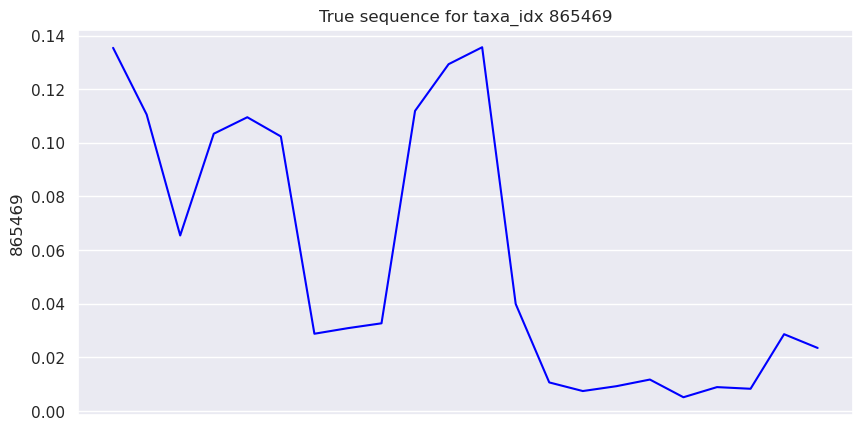

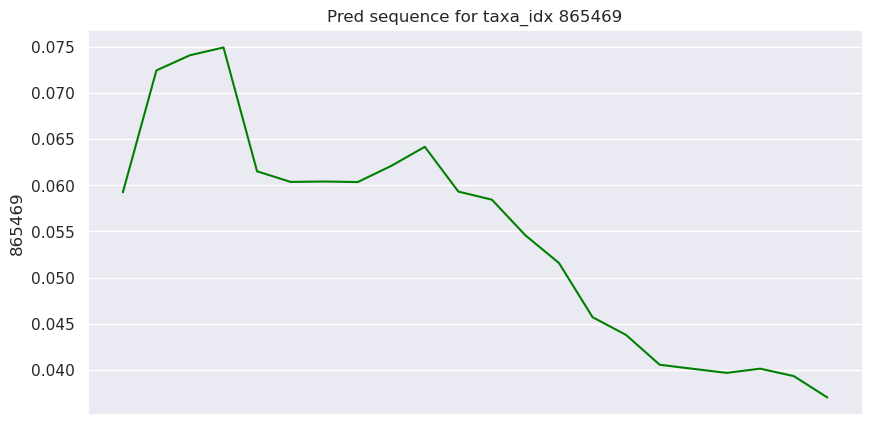

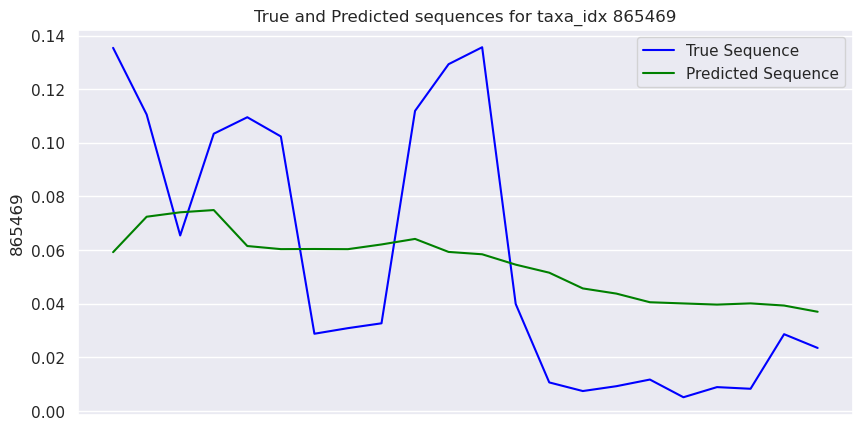

In [16]:
target_taxa = 865469
target_subject_idx = 0

target_subject = test_subjects[target_subject_idx]

true_sequence = test_subject_targets_df[target_taxa].reset_index(drop=True)
pred_sequence = test_subject_y_pred_df[target_taxa].reset_index(drop=True)

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences and test subjects. Errors are calculated individually by test subjects and then averaged

In [17]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

1/1 [==============================] - 0s 20ms/step


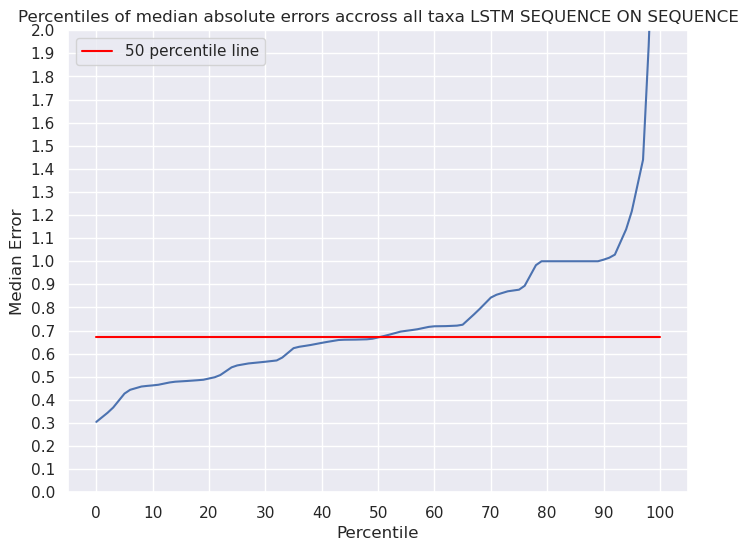

In [18]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [19]:
only_predicted_taxa = test_subject_y_pred_df.columns[~(test_subject_y_pred_df.columns.isin(non_predicted_taxa))]
only_predicted_errors = errors_df[only_predicted_taxa]
only_predicted_errors.describe()

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,2415144,351231,360015,3426658,312140,301578,577170,193233,196664,583117
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
unique,61.000000,58.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,60.000000
top,0.562603,1.000000,2.596824,0.393131,0.904474,0.564910,0.215643,4.761143,12.651291,0.443792,...,1.546849,0.013900,0.780382,0.481852,0.300713,0.246032,0.215710,0.717326,0.890797,1.000000
freq,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


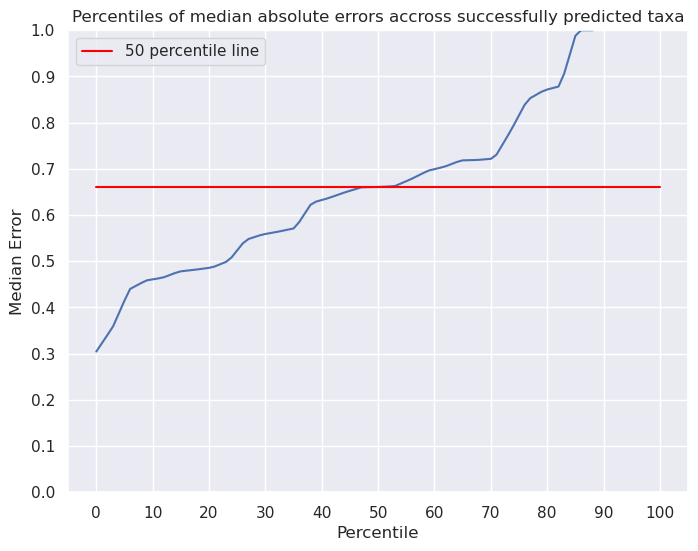

In [20]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)

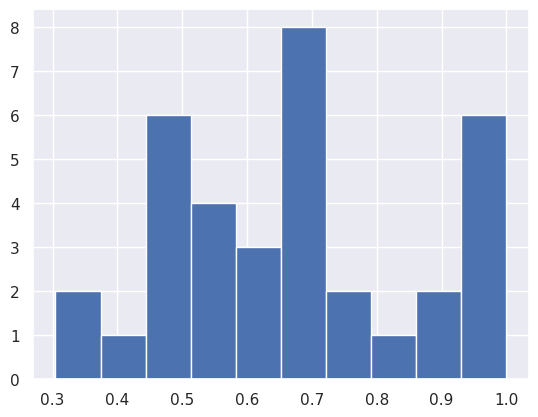

In [21]:
plt.hist(only_predicted_errors.median().clip(0, 1))
plt.show()

## Errors versus feature populations

In [22]:
population_rates = calculate_non_zero_value_percentages(df).drop(['subject_id', 'sampling_day'])

What are the average population rates in the taxa that are predicted by this model compared to the ones that arent?

In [23]:
population_rates[non_predicted_taxa].mean()

0.9877970456005137

In [24]:
population_rates[only_predicted_taxa].mean()

0.9597027250206441

Among the predicted taxa, is the median error somehow related to the population rate?

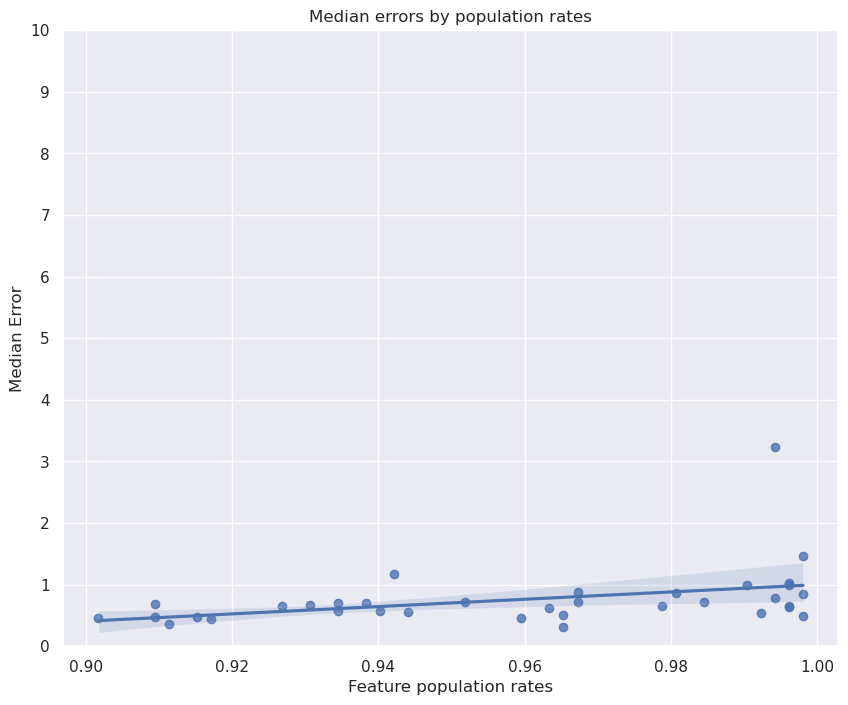

In [25]:
median_errors_by_population_rate(df, only_predicted_errors, only_predicted_taxa)